# Analyzing Crowdedness at the Gym with Stochastic Gradient Descent 

In this guided project, I'll create a multiple linear regression model predicting times when the gym is most crowded. The model will use stochastic gradient descent to find its ideal parameters.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from time import perf_counter

import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
import seaborn as sns

## Import and Inspect Data

In [2]:
gym = pd.read_csv("../Datasets/crowdness_gym_data.csv", parse_dates=['date'])

In [3]:
print(print(gym.shape))
print(gym.info())

(62184, 11)
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB
None


In [4]:
numerical_vars = ['temperature']
categorical_vars = ['day_of_week', 'is_weekend', 'is_holiday', 'is_start_of_semester', 'is_during_semester', 'month', 'hour']
needs_dummies = ['month', 'day_of_week', 'hour']

In [5]:
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [6]:
print(f"Missing Data: \n{gym.isnull().sum()}")

Missing Data: 
number_people           0
date                    0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64


In [7]:
print(gym.describe())

       number_people     timestamp   day_of_week    is_weekend    is_holiday  \
count   62184.000000  62184.000000  62184.000000  62184.000000  62184.000000   
mean       29.072543  45799.437958      2.982504      0.282870      0.002573   
std        22.689026  24211.275891      1.996825      0.450398      0.050660   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         9.000000  26624.000000      1.000000      0.000000      0.000000   
50%        28.000000  46522.500000      3.000000      0.000000      0.000000   
75%        43.000000  66612.000000      5.000000      1.000000      0.000000   
max       145.000000  86399.000000      6.000000      1.000000      1.000000   

        temperature  is_start_of_semester  is_during_semester         month  \
count  62184.000000          62184.000000        62184.000000  62184.000000   
mean      58.557108              0.078831            0.660218      7.439824   
std        6.316396              0.269476 

In [8]:
for var in categorical_vars:
    print(gym[var].value_counts(normalize=True).sort_index(), '\n')

0    0.142127
1    0.146822
2    0.144426
3    0.143542
4    0.140213
5    0.141869
6    0.141001
Name: day_of_week, dtype: float64 

0    0.71713
1    0.28287
Name: is_weekend, dtype: float64 

0    0.997427
1    0.002573
Name: is_holiday, dtype: float64 

0    0.921169
1    0.078831
Name: is_start_of_semester, dtype: float64 

0    0.339782
1    0.660218
Name: is_during_semester, dtype: float64 

1     0.065065
2     0.057684
3     0.069680
4     0.044175
5     0.068024
6     0.063360
7     0.071514
8     0.097919
9     0.111186
10    0.116815
11    0.114338
12    0.120240
Name: month, dtype: float64 

0     0.047890
1     0.028657
2     0.024444
3     0.024395
4     0.023109
5     0.039254
6     0.044352
7     0.044883
8     0.044995
9     0.045012
10    0.044963
11    0.044883
12    0.045108
13    0.045221
14    0.044819
15    0.044674
16    0.045156
17    0.046813
18    0.045623
19    0.045333
20    0.044947
21    0.044690
22    0.044626
23    0.046153
Name: hour, dtype: float64 


## Inspect relationships of predictors to outcome variable

temperature      0.373327
number_people    1.000000
Name: number_people, dtype: float64


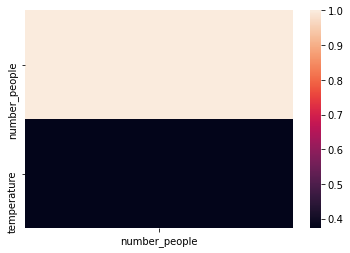

In [9]:
gym_corr = gym[['number_people'] + numerical_vars].corr()
sns.heatmap(gym_corr[['number_people']])
print(gym_corr['number_people'].sort_values())

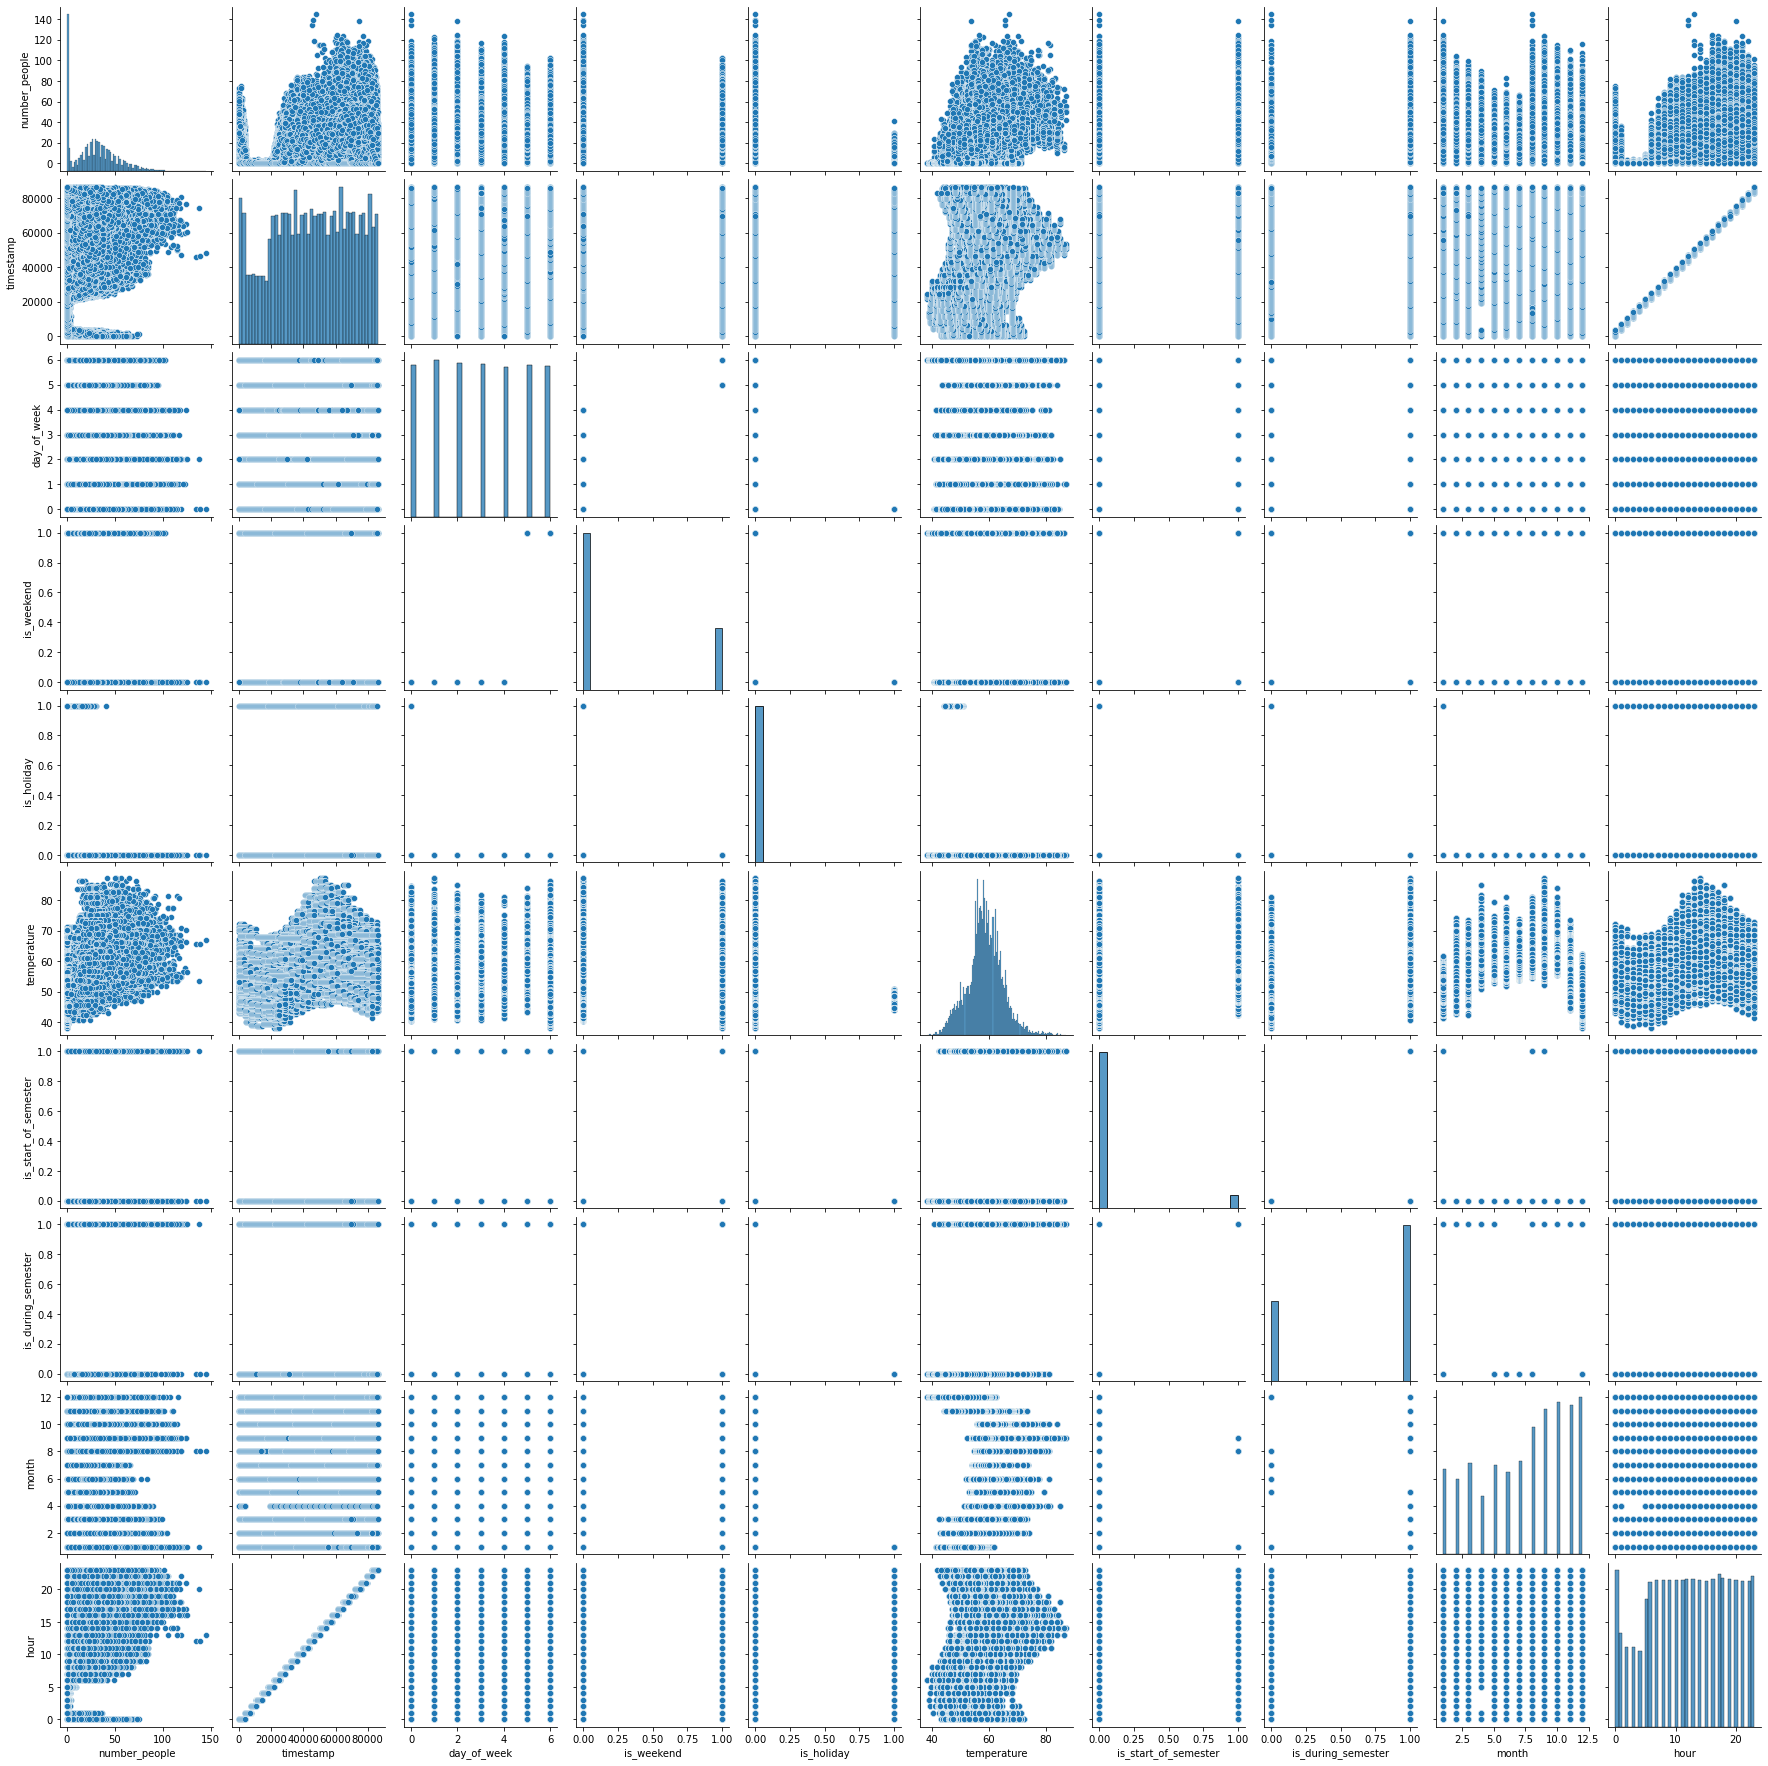

In [10]:
sns.pairplot(gym)

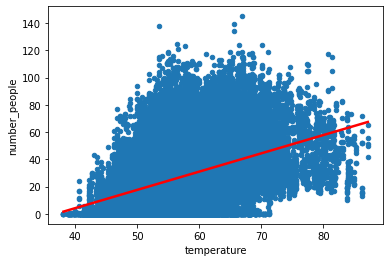

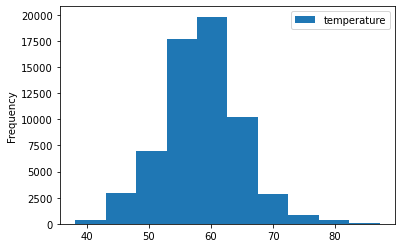

In [11]:
for var in numerical_vars:
    gym.plot.scatter(y='number_people', x=var)
    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    b, a = np.polyfit(gym[var], gym['number_people'], deg=1)
    # create number sequence along which to plot
    xseq = np.linspace(gym[var].min(), gym[var].max(), num=100)
    # Plot regression line
    plt.plot(xseq, a + b * xseq, color="red", lw=2.5);
    plt.show()
    
    # plot histogram
    gym[[var]].plot.hist()
    plt.show()

### Apparent effects of numerical variables

- `temperature`: more people appear to visit the gym when the temperature is higher, although this effect appears quadratic.

In [12]:
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


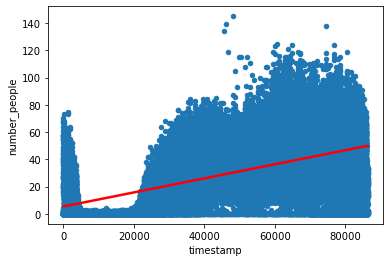

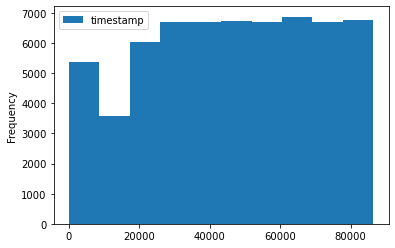

In [13]:
gym.plot.scatter(y='number_people', x='timestamp')
# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
b, a = np.polyfit(gym['timestamp'], gym['number_people'], deg=1)
# create number sequence along which to plot
xseq = np.linspace(gym['timestamp'].min(), gym['timestamp'].max(), num=100)
# Plot regression line
plt.plot(xseq, a + b * xseq, color="red", lw=2.5);
plt.show()

# plot histogram
gym[['timestamp']].plot.hist()
plt.show()

                  mean        std
day_of_week                      
0            32.653315  23.883719
1            32.435926  23.320799
2            32.441376  22.890137
3            30.217455  22.285293
4            29.957105  22.952443
5            22.956699  20.728320
6            22.618613  19.845487 



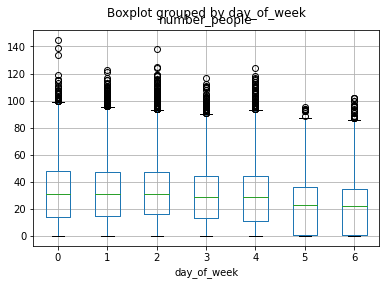

                 mean        std
is_weekend                      
0           31.551397  23.101913
1           22.788175  20.293187 



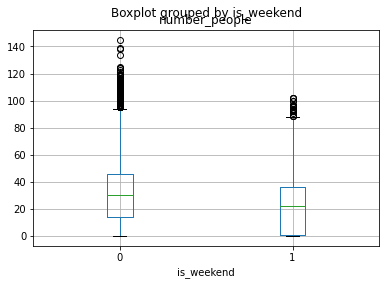

                 mean        std
is_holiday                      
0           29.128144  22.686649
1            7.518750   9.560777 



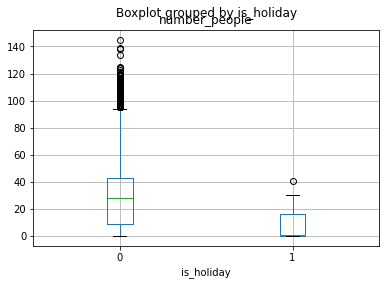

                           mean        std
is_start_of_semester                      
0                     27.860026  21.820121
1                     43.241330  27.366539 



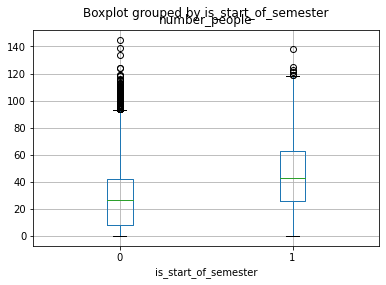

                         mean        std
is_during_semester                      
0                   18.466468  16.098791
1                   34.530971  23.636156 



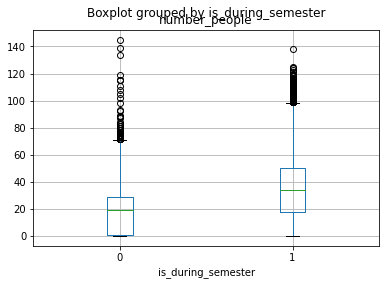

            mean        std
month                      
1      33.459713  27.196201
2      39.218846  22.248490
3      33.249019  20.138809
4      38.538406  18.696611
5      19.837116  14.608202
6      20.309137  15.361395
7      20.730380  15.564731
8      26.744129  20.971029
9      38.817038  25.718782
10     33.761564  24.153928
11     28.806892  22.662129
12     19.319781  20.616321 



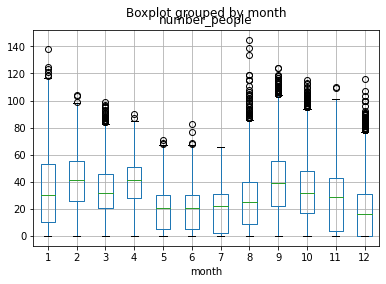

           mean        std
hour                      
0     14.720282  15.347525
1      2.404040   5.302055
2      0.178289   0.443432
3      0.145023   0.409401
4      0.279054   0.549182
5      1.045063   1.317450
6      8.763234   8.154084
7     15.393049  12.502900
8     24.054325  13.662013
9     30.190068  14.595216
10    33.733906  16.110153
11    36.219635  15.879456
12    36.110517  14.996216
13    34.572902  14.736558
14    33.931109  14.945423
15    37.197624  16.251562
16    42.959402  19.345465
17    47.637582  22.275737
18    48.297850  21.186586
19    44.741043  21.845910
20    41.669767  21.912971
21    42.922634  23.205257
22    40.463784  22.512226
23    26.147038  23.248052 



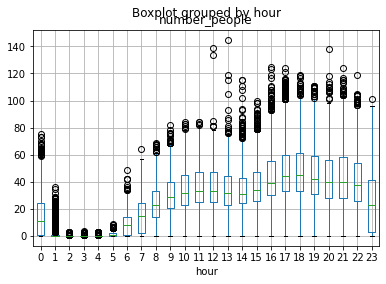

In [14]:
for var in categorical_vars:
    cat_means = gym.groupby(var)['number_people'].agg(['mean', 'std'])
    print(cat_means, '\n')
    gym.boxplot(column='number_people', by=var)
    plt.show()

### Apparent effects of categorical variables

- `day_of_the_week`: there appears to be an effect. People seem to visit the gym most Monday-Wednesday, with a slight dip Thursday-Friday, and another dip over the weekend. It's not clear that this variable and `is_weekend` are both necessary.
- `is_holiday`: there appears to be an effect. People seem to visit the gym less on holidays. 
- `is_start_of_semester`: there appears to be an effect. People seem to visit the gym more at the start of the semester.
- `is_during_semester`: there appears to be an effect. People seem to visit the gym more during the semester.
- `is_weekend`: there appears to be an effect. People seem to visit the gym less on weekends. This may explain supplant the `day_of_the_week` variable, which doesn't show very strong changes outside the weekend/weekday boundary.
- `month`: there appear to be an effect. May-July and December appear to be low traffic months, whereas September, February, and April appear to be high traffic months.
- `hour`: there are clear effects of hour, where very few people visit between 1:00 and 2:00 and the most people visit between 16:00 and 22:00. 

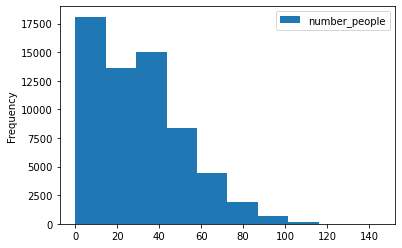

In [15]:
gym[['number_people']].plot.hist()
plt.show()

In [16]:
gym[['number_people']].describe()

,number_people
count,62184.000000
mean,29.072543
std,22.689026
min,0.000000
25%,9.000000
50%,28.000000
75%,43.000000
max,145.000000


### Comments on dependent variable

Number of people has a pretty strong positive skew, so we might want to see if we can correct that for the sake of later model residuals.

In [17]:
boxcox(gym.loc[gym['number_people']>0, 'number_people'])[0]

array([13.88533831, 15.91910629, 14.66538673, ..., 10.49503726,
        8.23357372,  9.8759128 ])

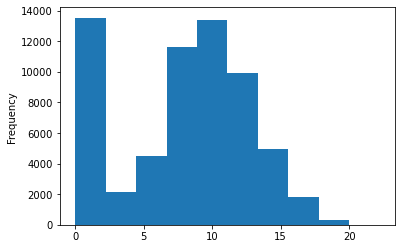

Boxcox lambda: 0.6309872442389322


In [18]:
gym['number_people_boxcox'] = boxcox(gym['number_people']+1)[0]
gym['number_people_boxcox'].plot.hist()
plt.show()
boxcox_lambda_nr_people = boxcox(gym.loc[gym['number_people']>0, 'number_people'])[1]
print(f"Boxcox lambda: {boxcox_lambda_nr_people}")

### Comment on DV transformation

The number of people variable can be made more normal--albeit with another distribution peak made at '0'--by a boxcox transformation. We might want to run the analysis without this transformation first to see whether the results are acceptable and then run another analysis with the transformation to compare the two. We will be concerned with the amount of variance explained and the ease of interpretation between the models.

## Create data subsets for modeling

In [19]:
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour,number_people_boxcox
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17,10.346920
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17,11.586205
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17,10.825653
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17,11.437529
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17,11.586205


In [20]:
gym_dum = pd.get_dummies(data=gym, columns=needs_dummies, drop_first=True)

In [21]:
X = gym_dum.copy().drop(columns=['number_people', 'date', 'timestamp', 'number_people_boxcox'])
y = gym_dum['number_people']

In [22]:
X.columns

Index(['is_weekend', 'is_holiday', 'temperature', 'is_start_of_semester',
       'is_during_semester', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')

In [23]:
_scaler = StandardScaler()
_scaler.fit(X)
X_scaled = _scaler.transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=444)

## Create model on untransformed DV

In [25]:
tic = perf_counter()
sgdr = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='huber', 
    penalty='elasticnet', random_state=4)
sgdr.fit(X_train, y_train)
y_pred = sgdr.predict(X_test) 
toc = perf_counter()
print(f"Finished SGDR model in {toc - tic:0.4f} seconds")

Finished SGDR model in 0.2310 seconds


In [26]:
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_R2 = r2_score(y_test, y_pred)
sgdr_coef = sgdr.coef_

In [27]:
print(
f"Test MSE: {round(test_mse,3)}\n\
Test RMSE: {round(test_rmse,3)}\n\
Test R^2: {round(test_R2,3)}\n\
Model coefficients: {sgdr_coef}")

Test MSE: 201.448
Test RMSE: 14.193
Test R^2: 0.609
Model coefficients: [-2.10187653 -0.62961886  3.27374456  1.24433095  5.09430753  0.15263905
 -1.80663325 -0.34241323 -2.39634852 -1.05734171 -0.89985308 -1.57390636
 -1.78351624 -3.17630131 -3.26788221 -3.14028657  0.22719665 -0.01047384
 -0.03674576 -0.85860588 -1.19849312 -1.39218165 -1.92382403 -1.8675639
 -1.98847492 -1.75194809 -2.52206605 -1.11322391  0.          1.47101514
  2.65159679  3.05111666  3.28538753  3.40439205  3.02820292  2.78401051
  3.27952329  4.36771455  5.62284908  5.8799807   5.26662406  4.7406601
  4.86793157  4.40141014  1.6251708 ]


### Examine model residuals

In [28]:
residuals = y_test-y_pred
print(f"Test model residual mean: {round(np.mean(residuals), 3)}")

Test model residual mean: 1.711


The residual mean is good. We'd rather have it closer to zero, but it is reasonably good.

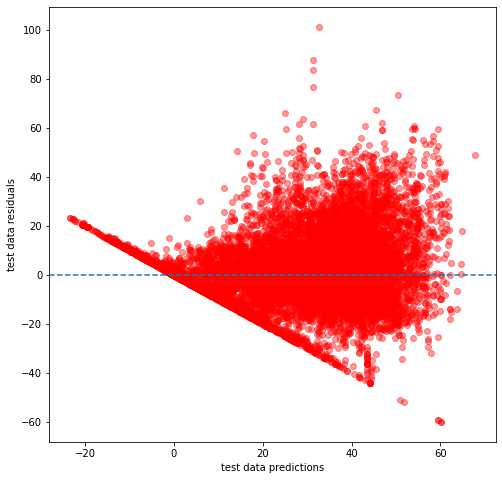

In [29]:
plt.figure(figsize=[8,8])
plt.scatter(y_pred, residuals, color = 'red', alpha=0.4)
plt.xlabel('test data predictions')
plt.ylabel('test data residuals')
plt.axhline(0, ls='--')
plt.show()

A plot of the predicted vs. residual values in the test data shows that the variance of residuals was highly different across the dataset--to the point where there appears to be a strong linear trend in the prediction error as well as a extreme increase in varaince as predictions increase (heteroskedasticity). This means our model is not a good one, despite our reasonably good R^2.

The heteroskedasticity in our predictions means that our model captures low gym visitation rates much better than it captures high visitation rates. The linear pattern may mean that we are missing a variable

## Create Second Model on Boxcox Transformed DV

In [30]:
y2 = gym_dum['number_people_boxcox']

In [31]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_scaled, y2, test_size=0.2, random_state=4444)

In [32]:
tic = perf_counter()
sgdr_boxcox = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='huber', 
    penalty='elasticnet', random_state=4)
sgdr_boxcox.fit(X2_train, y2_train)
y2_pred = sgdr.predict(X2_test) 
toc = perf_counter()
print(f"Finished SGDR model in {toc - tic:0.4f} seconds")

Finished SGDR model in 0.2629 seconds


In [33]:
test_mse_boxcox = mean_squared_error(y2_test, y2_pred)
test_rmse_boxcox = mean_squared_error(y2_test, y2_pred, squared=False)
test_R2_boxcox = r2_score(y2_test, y2_pred)
sgdr_boxcox_coef = sgdr.coef_

In [34]:
print(
    f"Test MSE: {round(test_mse_boxcox,3)}\n\
Test RMSE: {round(test_rmse_boxcox,3)}\n\
Test R^2: {round(test_R2_boxcox,3)}\n\
Model coefficients: {sgdr_boxcox_coef}")

Test MSE: 525.684
Test RMSE: 22.928
Test R^2: -21.595
Model coefficients: [-2.10187653 -0.62961886  3.27374456  1.24433095  5.09430753  0.15263905
 -1.80663325 -0.34241323 -2.39634852 -1.05734171 -0.89985308 -1.57390636
 -1.78351624 -3.17630131 -3.26788221 -3.14028657  0.22719665 -0.01047384
 -0.03674576 -0.85860588 -1.19849312 -1.39218165 -1.92382403 -1.8675639
 -1.98847492 -1.75194809 -2.52206605 -1.11322391  0.          1.47101514
  2.65159679  3.05111666  3.28538753  3.40439205  3.02820292  2.78401051
  3.27952329  4.36771455  5.62284908  5.8799807   5.26662406  4.7406601
  4.86793157  4.40141014  1.6251708 ]


Very bad R^2 this time.

### Examine model residuals

In [35]:
residuals_boxcox = y2_test-y2_pred
print(f"Test model residual mean: {round(np.mean(residuals_boxcox), 3)}")

Test model residual mean: -19.188


The residual mean is much worse.

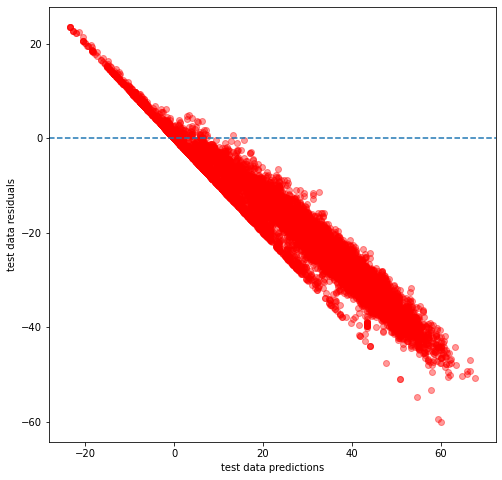

In [36]:
plt.figure(figsize=[8,8])
plt.scatter(y2_pred, residuals_boxcox, color = 'red', alpha=0.4)
plt.xlabel('test data predictions')
plt.ylabel('test data residuals')
plt.axhline(0, ls='--')
plt.show()

We get the same problem with residuals here, although the fanning of variance from low to high predictions is not as extreme as in the untransformed model and our prediction errors are strongly biased toward underpredicting gym traffic. 

### Attempting to Improve the Model

Several factors may improve our model:

- The zero values in the DV may be removed to make our data more unimodal, although predictions are not worst at lower numbers of people. We may prefer the boxcox variable, since its distribution is more normal.
- Temperature may be modeled with a quadratic term to better fit the data.
- Redundancy may be removed by eliminating `day_of_week`, since this variable seems to cover the same facts as `is_weekend`
- `hour` may be better modeled as a continuous variable with a quadratic term. If we shift the labeling, the data follow a negative quadratic trend from 2\:00-1\:00

These changes will have the added benefit of decreasing the number of predictor variables as well, especially by having `hour` be continuous and dropping `day_of_week`.

In [37]:
gym_dum2 = pd.get_dummies(data=gym, columns=['month'], drop_first=True)

In [38]:
# remove zero values from DV
gym_dum2 = gym_dum2[gym_dum2['number_people_boxcox']>0]

# create quadratic temperature variable
gym_dum2['temperature_sq'] = gym_dum2['temperature']**2

# shift `hour` variable and create quadratic term
gym_dum2.loc[gym_dum2['hour']==0, 'hour'] = 25
gym_dum2.loc[gym_dum2['hour']==1, 'hour'] = 26
gym_dum2['hour_sq'] = gym_dum2['hour']**2

In [39]:
print(gym_dum.shape, gym_dum2.shape)
gym_dum2.head()

(62184, 49) (53409, 24)


,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,hour,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,temperature_sq,hour_sq
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,17,...,0,0,0,1,0,0,0,0,5149.4976,289
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,17,...,0,0,0,1,0,0,0,0,5149.4976,289
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,17,...,0,0,0,1,0,0,0,0,5149.4976,289
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,17,...,0,0,0,1,0,0,0,0,5149.4976,289
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,17,...,0,0,0,1,0,0,0,0,5149.4976,289


In [40]:
X3 = gym_dum2.copy().drop(columns=['number_people', 'date', 'timestamp', 'number_people_boxcox', 'day_of_week'])
y3 = gym_dum2['number_people_boxcox']

In [41]:
X3.columns

Index(['is_weekend', 'is_holiday', 'temperature', 'is_start_of_semester',
       'is_during_semester', 'hour', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'temperature_sq', 'hour_sq'],
      dtype='object')

In [42]:
_scaler = StandardScaler()
_scaler.fit(X3)
X3_scaled = _scaler.transform(X3)

In [43]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_scaled, y3, test_size=0.2, random_state=444)

## Create Third Model on Improved Data

In [44]:
tic = perf_counter()
sgdr3 = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='huber', 
    penalty='elasticnet', random_state=4)
sgdr3.fit(X3_train, y3_train)
y3_pred = sgdr3.predict(X3_test) 
toc = perf_counter()
print(f"Finished SGDR model in {toc - tic:0.4f} seconds")

Finished SGDR model in 0.1012 seconds


In [45]:
test_mse_m3 = mean_squared_error(y3_test, y3_pred)
test_rmse_m3 = mean_squared_error(y3_test, y3_pred, squared=False)
test_R2_m3 = r2_score(y3_test, y3_pred)
sgdr3_coef = sgdr3.coef_

In [46]:
print(
f"Test MSE: {round(test_mse_m3,3)}\n\
Test RMSE: {round(test_rmse_m3,3)}\n\
Test R^2: {round(test_R2_m3,3)}\n\
Model coefficients: {sgdr3_coef}")

Test MSE: 6.781
Test RMSE: 2.604
Test R^2: 0.554
Model coefficients: [-0.63752428 -0.18760492  2.51813301  0.1894055   1.36090257  9.49278943
 -0.21685521 -0.62972603 -0.19448151 -0.57058729 -0.34146958 -0.21807829
 -0.46347868 -0.39963954 -0.85168214 -0.63823868 -0.88506379 -1.99640796
 -8.49792212]


R^2 pretty good again, but worse than the first model.

### Examine model residuals

In [47]:
residuals_m3 = y3_test-y3_pred
print(f"Test model residual mean: {round(np.mean(residuals_m3), 3)}")

Test model residual mean: -0.109


The residual mean is very good. We'd rather have it closer to zero, but it is the best of all models.

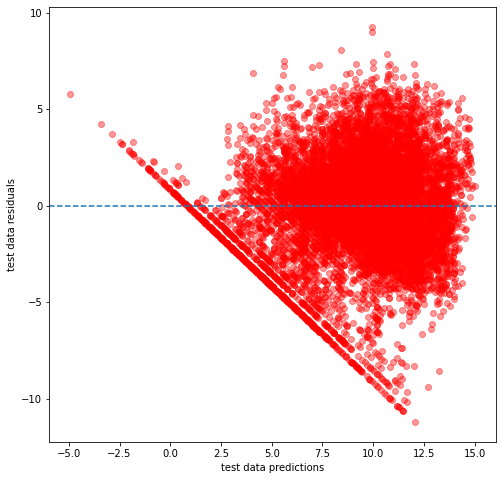

In [48]:
plt.figure(figsize=[8,8])
plt.scatter(y3_pred, residuals_m3, color = 'red', alpha=0.4)
plt.xlabel('test data predictions')
plt.ylabel('test data residuals')
plt.axhline(0, ls='--')
plt.show()

Despite our improvements, the updated model has the same issues as the previous models. The residuals persist to have a strong linear trend and strong heteroskedasticity. The residuals are smaller in this model by quite a bit, which is a definite improvement, but it is not clear that this improvement is meaningful, given the decreased R^2 and persistent residual issues.

## Conclusions

Our model of gym visiting was not very good. We could make a decent prediction about how many people would be at the gym given several variables: the outside temperature, hour of day, day of week, month of the year, whether it was a weekend, whether it was the beginning of the semester, whether it was during the semester, and whether it was a holiday. However, as our model's predictions increased, they contained more error. Furthermore, looking at our model's errors indicates that we are likely missing important explanatory variables. 

If one desires to visit the gym at a time when fewer people are present, our model could be used as a rough approximation of when to use the gym, as the predictions are better for when there will be fewer visitors. However, a look at the mean number of gym visitors on a few variables (e.g., hour of day, day of week, month) could also give us a similar idea without resorting to a complex model.